# 丛集模式分析

In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_cn = FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")
font_en = FontProperties(fname=r"C:\Windows\Fonts\times.ttf")


## 1.小时+工作日非工作日级别丛集模式的流量统计
  - （24h/工作日非工作日）统计丛集模式的总流量，刻画丛集模式的时间分布特征（上下两个柱状图比较）

In [41]:
def plot_cluster_flow_time_distribution_by_files(folder_path: str):
    """
    基于已分好时间切片的文件，统计丛集模式流量并绘制双柱状图
    （每个小时两根柱：左工作日，右非工作日）
    """

    # 初始化 24h × 2
    flow_workday = np.zeros(24)
    flow_nonworkday = np.zeros(24)

    # 文件名示例：od_flow_cluster_工作日_0.csv
    pattern = re.compile(r"_(工作日|非工作日)_(\d+)\.csv")

    for fname in os.listdir(folder_path):
        match = pattern.search(fname)
        if not match:
            continue

        day_type, hour = match.groups()
        hour = int(hour)

        df = pd.read_csv(os.path.join(folder_path, fname))

        # 只保留丛集模式流
        df = df[df["cluster_id"] != -1]

        # 该时间切片的丛集模式总流量
        flow_sum = df["flow_num"].sum()

        if day_type == "工作日":
            flow_workday[hour] += flow_sum
        else:
            flow_nonworkday[hour] += flow_sum

    # ---------- 绘图 ----------
    fig, ax = plt.subplots(figsize=(10, 4))

    x = np.arange(24)
    bar_width = 0.4

    ax.bar(
        x - bar_width / 2,
        flow_workday,
        width=bar_width,
        label="工作日"
    )
    ax.bar(
        x + bar_width / 2,
        flow_nonworkday,
        width=bar_width,
        label="非工作日"
    )
    
    ax.set_xticks(x)
    ax.set_xticklabels(
        [f"{h}-{h+1}" for h in x],
        rotation=45,
        ha="right"
    )
    # ax.set_xlabel("时间段（小时）")
    # ax.set_ylabel("丛集模式总流量")
    # ax.set_title("丛集模式共享单车流量的时间分布特征")
    ax.set_title(
        "丛集模式共享单车流量时间分布",
        fontproperties=font_cn
    )
    ax.set_xlabel(
        "时间段（小时）",
        fontproperties=font_cn
    )

    ax.set_ylabel(
        "丛集模式流量（次）",
        fontproperties=font_cn
    )

    ax.legend(
        prop=font_cn
    )
    plt.tight_layout()

    return fig, ax

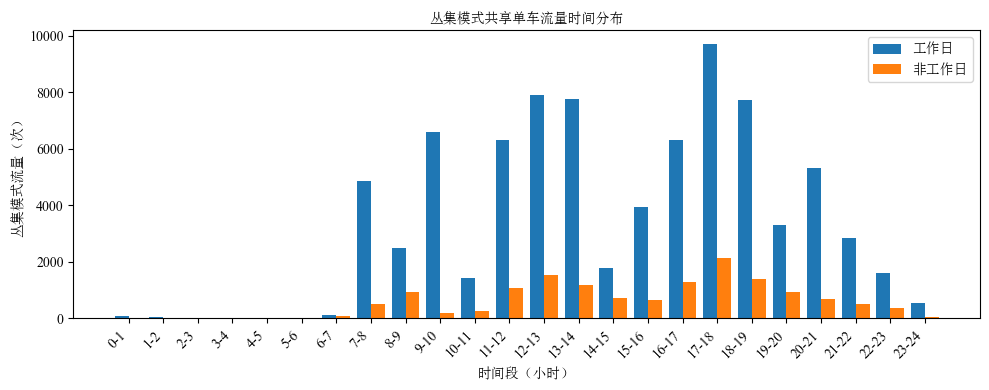

In [42]:
fig, ax = plot_cluster_flow_time_distribution_by_files(r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters")
fig.savefig("01_cluster_distributions.png", dpi=500)

## 2. 单时间段的流分析——流可视化（单线条，粗细代表流量大小）

### kepler可视化流图

In [55]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from keplergl import KeplerGl

def plot_top_flows_kepler(file_path: str, top_n: int = 20, lonlat_crs: str = "EPSG:4326", map_height: int = 700):
    """
    绘制流量前 top_n 的簇流可视化（KeplerGl），带线宽映射和流向箭头（arc）。
    
    参数
    ----
    file_path : str
        CSV 文件路径，必须包含列：
        ["cluster_id", "origin_lon", "origin_lat", "destination_lon", "destination_lat", "flow_num"]
    top_n : int
        只显示流量前 top_n 的簇
    lonlat_crs : str
        坐标参考系，默认 "EPSG:4326"
    map_height : int
        Kepler 地图高度，默认 700
    
    返回
    ----
    KeplerGl 对象
    """

    # 1. 读数据
    df = pd.read_csv(file_path)
    required_cols = ["cluster_id", "origin_lon", "origin_lat", "destination_lon", "destination_lat", "flow_num"]
    missing = set(required_cols) - set(df.columns)
    if missing:
        raise ValueError(f"缺少字段: {missing}")

    # 2. 聚合 cluster 层面
    cluster_flow = (
        df.groupby("cluster_id")
          .agg(
              ox=("origin_lon", "mean"),
              oy=("origin_lat", "mean"),
              dx=("destination_lon", "mean"),
              dy=("destination_lat", "mean"),
              flow=("flow_num", "sum")
          )
          .reset_index()
    )

    # 3. 只保留流量前 top_n
    cluster_flow = cluster_flow.nlargest(top_n, "flow")

    # 4. 构建 LineString
    cluster_flow["geometry"] = cluster_flow.apply(lambda r: LineString([(r.ox, r.oy), (r.dx, r.dy)]), axis=1)

    # 5. 转 GeoDataFrame
    gdf = gpd.GeoDataFrame(cluster_flow, geometry="geometry", crs=lonlat_crs)

    # 6. 创建 KeplerGl 地图
    center = {"latitude": 30.54, "longitude": 114.36, "zoom": 14}
    map_ = KeplerGl(
        height=map_height,
        config={
            "version": "v1",
            "config": {
                "mapStyle": {"styleType": "light"},
                "visState": {
                    "layers": [
                        {
                            "id": "cluster-flow-arc",
                            "type": "arc",
                            "config": {
                                "dataId": "cluster_flows",
                                "label": "Cluster Flow Arc",
                                "color": [180, 0, 0],
                                "columns": {
                                    "lat0": "oy",
                                    "lng0": "ox",
                                    "lat1": "dy",
                                    "lng1": "dx"
                                },
                                "isVisible": True,
                                "visConfig": {
                                    "thickness": 2,
                                    "sizeRange": [2, 60],  # 最大线宽加粗
                                    "strokeOpacity": 1
                                }
                            },
                            "visualChannels": {
                                "sizeField": {"name": "flow", "type": "integer"},
                                "sizeScale": "linear"  # 线性映射流量
                            }
                        }
                    ]
                },
                "mapState": {
                    "latitude": center["latitude"],
                    "longitude": center["longitude"],
                    "zoom": center["zoom"],
                    "bearing": 0,
                    "pitch": 0
                }
            }
        }
    )

    # 7. 加载数据
    map_.add_data(data=gdf, name="cluster_flows")
    return map_


In [56]:
map_ = plot_top_flows_kepler(
    r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters\od_flow_cluster_工作日_17.csv"
)
map_.save_to_html(
    file_name="01_cluster_visualization_工作日_17.html"
)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to 01_cluster_visualization_工作日_17.html!


### 单线条流图数据预处理（最后放置在qgis可视化）

In [34]:
import pandas as pd

def aggregate_cluster_flows_with_attrs(input_csv: str, output_csv: str):
    """
    将原始共享单车 OD 数据整理成簇流格式（起终点 + 流量总和 + 保留字段），用于 QGIS 可视化。
    
    参数
    ----
    input_csv : str
        原始 OD 数据 CSV 文件路径，必须包含 cluster_id 和 flow_num 字段
    output_csv : str
        输出 CSV 文件路径
    """
    
    # 1. 读取数据
    df = pd.read_csv(input_csv)
    
    required_cols = ["cluster_id","origin_lon","origin_lat","destination_lon","destination_lat","flow_num"]
    missing = set(required_cols) - set(df.columns)
    if missing:
        raise ValueError(f"缺少字段: {missing}")
    
    # 保留的其他字段
    extra_cols = [
        "distance_m","riding_time_s","is_workday",
        "origin_id","destination_id",
        "semantics_origin","semantics_dest",
        "semantics_id_origin","semantics_id_dest",
        "category_origin","category_dest",
        "category_id_origin","category_id_dest"
    ]
    
    # 2. 去掉噪声簇
    df = df[df["cluster_id"] != -1]
    
    # 3. 聚合簇流
    agg_dict = {
        "origin_lon":"mean",
        "origin_lat":"mean",
        "destination_lon":"mean",
        "destination_lat":"mean",
        "flow_num":"sum"
    }
    
    # 数值型字段取均值
    num_cols = ["distance_m","riding_time_s"]
    for c in num_cols:
        if c in df.columns:
            agg_dict[c] = "mean"
    
    # 分类/字符串型字段取最常见值
    cat_cols = [
        "is_workday","origin_id","destination_id",
        "semantics_origin","semantics_dest",
        "semantics_id_origin","semantics_id_dest",
        "category_origin","category_dest",
        "category_id_origin","category_id_dest"
    ]
    for c in cat_cols:
        if c in df.columns:
            agg_dict[c] = lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
    
    cluster_flow = df.groupby("cluster_id").agg(agg_dict).reset_index()
    
    # 4. 重命名列
    cluster_flow = cluster_flow.rename(columns={
        "origin_lon":"ox",
        "origin_lat":"oy",
        "destination_lon":"dx",
        "destination_lat":"dy",
        "flow_num":"flow"
    })
    
    # 5. 按 flow 降序排列
    cluster_flow = cluster_flow.sort_values(by="flow", ascending=False).reset_index(drop=True)
    
    # 6. 输出 CSV
    cluster_flow.to_csv(output_csv, index=False)
    print(f"已生成簇流 CSV: {output_csv}，共 {len(cluster_flow)} 条簇流记录")
    
    return cluster_flow


In [36]:
cluster_df = aggregate_cluster_flows_with_attrs(
    input_csv=r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters\od_flow_cluster_工作日_17.csv",
    output_csv=r"H:\code\shared_bike_pattern_mining\01_cluster_工作日_17_for_qgis.csv"
)


已生成簇流 CSV: H:\code\shared_bike_pattern_mining\01_cluster_工作日_17_for_qgis.csv，共 770 条簇流记录


## 3.丛集模式语义*语义流量矩阵绘制

In [53]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_category_flow_matrix(
    file_path: str,
    origin_col: str = "category_origin",
    dest_col: str = "category_dest",
    flow_col: str = "flow_num",
    figsize: tuple = (10, 8),
    cmap: str = "Blues"
):
    """
    绘制 category_origin → category_dest 的语义流量矩阵

    Parameters
    ----------
    file_path : str
        CSV 文件路径
    origin_col : str
        起点语义类别字段名
    dest_col : str
        终点语义类别字段名
    flow_col : str
        流量字段名（默认 flow_num）
    figsize : tuple
        图像尺寸
    cmap : str
        颜色映射（默认 Blues）

    Returns
    -------
    fig : matplotlib.figure.Figure
        生成的 Figure 对象
    """

    # 1. 读数据
    df = pd.read_csv(file_path)

    # 2. 聚合 category → category 流量
    mat = (
        df.groupby([origin_col, dest_col])[flow_col]
          .sum()
          .reset_index()
          .pivot(index=origin_col, columns=dest_col, values=flow_col)
          .fillna(0)
    )

    # 3. 保证横纵类别顺序一致
    categories = sorted(set(mat.index) | set(mat.columns))
    mat = mat.reindex(index=categories, columns=categories, fill_value=0)

    # 4. 绘图
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(mat.values, cmap=cmap)

    # 坐标轴
    ax.set_xticks(range(len(categories)))
    ax.set_yticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=45, ha="right",
                   fontproperties=font_cn)
    ax.set_yticklabels(categories,
                    fontproperties=font_cn)


    ax.set_title("工作日17-18h 语义—语义流量矩阵", fontproperties=font_cn,fontsize=16)
    ax.set_xlabel("起点语义类别", fontproperties=font_cn,fontsize=14)
    ax.set_ylabel("终点语义类别", fontproperties=font_cn,fontsize=14)


    # 颜色条
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("总流量", fontproperties=font_cn,fontsize=14)

    fig.tight_layout()

    return fig

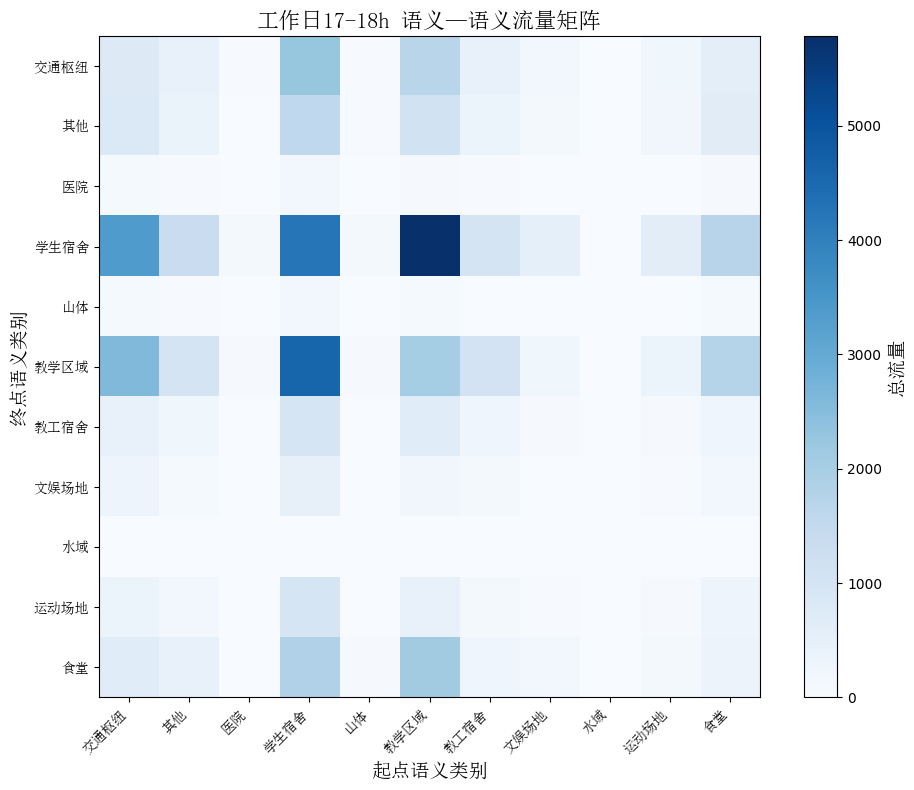

In [54]:
fig = plot_category_flow_matrix(r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters\od_flow_cluster_工作日_17.csv")
fig.savefig("01_category_flow_matrix.png", dpi=500)

## 4.CCDF图的绘制——找出典型丛集模式分布

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plot_cluster_flow_ccdf(
    file_path: str,
    cluster_col: str = "cluster_id",
    flow_col: str = "flow_num",
    noise_label: int = -1,
    figsize: tuple = (8, 6)
):
    """
    绘制丛集总流量的互补累计分布函数（CCDF）

    Parameters
    ----------
    file_path : str
        输入 CSV 文件路径
    cluster_col : str
        丛集 ID 字段名（默认 cluster_id）
    flow_col : str
        流量字段名（默认 flow_num）
    noise_label : int
        噪声簇标签（默认 -1）
    figsize : tuple
        图像大小

    Returns
    -------
    fig : matplotlib.figure.Figure
        CCDF 图的 Figure 对象
    """

    # 1. 读数据
    df = pd.read_csv(file_path)

    # 2. 去除噪声簇
    df = df[df[cluster_col] != noise_label]

    # 3. 计算每个簇的总流量
    cluster_flow = (
        df.groupby(cluster_col)[flow_col]
          .sum()
          .values
    )

    # 安全检查
    if len(cluster_flow) == 0:
        raise ValueError("去除噪声后没有有效的 cluster 数据")

    # 4. 计算 CCDF
    x = np.sort(cluster_flow)
    y = 1 - np.arange(1, len(x) + 1) / len(x)

    # 5. 绘图
    fig, ax = plt.subplots(figsize=figsize)

    ax.loglog(x, y, marker=".", linestyle="none")

    ax.set_xlabel("簇流量", fontproperties=font_cn,fontsize=14)
    ax.set_ylabel("P(X ≥ x)", fontproperties=font_en,fontsize=14)
    ax.set_title("工作日17-18h 互补累计分布（CCDF）", fontproperties=font_cn,fontsize=16)

    ax.grid(True, which="both", linestyle="--", alpha=0.4)

    fig.tight_layout()

    return fig

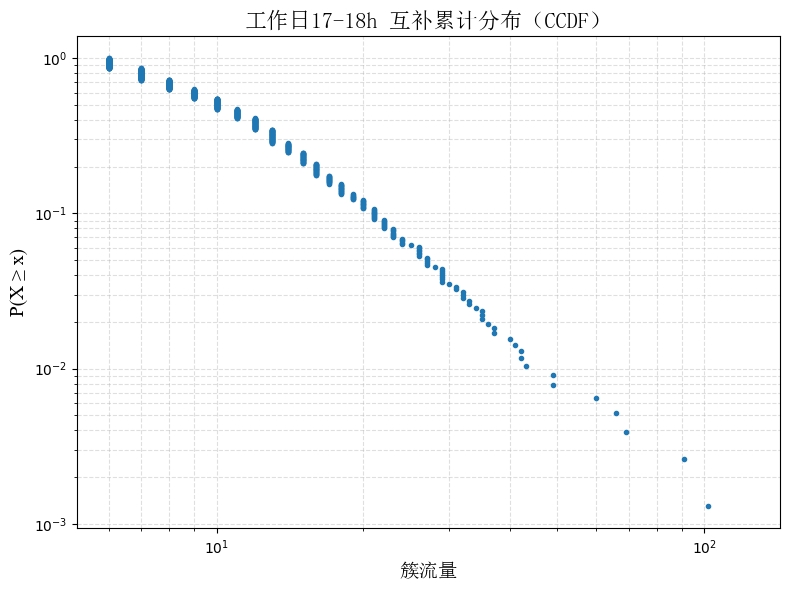

In [74]:
fig = plot_cluster_flow_ccdf(r"H:\code\shared_bike_pattern_mining\data\24_weekday_weekend_clusters\od_flow_cluster_工作日_17.csv")
fig.savefig("01_cluster_flow_ccdf_工作日_17.png", dpi=500)

## 5.典型丛集模式的时序分析